In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
df = pd.read_csv('/content/household_power_consumptionn.csv')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
0,4.216,0.418,234.84,18.4,0,1,17.0,12/16/2006 17:24
1,5.36,0.436,233.63,23,0,1,16.0,12/16/2006 17:25
2,5.374,0.498,233.29,23,0,2,17.0,12/16/2006 17:26
3,5.388,0.502,233.74,23,0,1,17.0,12/16/2006 17:27
4,3.666,0.528,235.68,15.8,0,1,17.0,12/16/2006 17:28


In [4]:
# Display basic information about the dataset
df.info(), df.describe(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1048575 non-null  object 
 1   Global_reactive_power  1048575 non-null  object 
 2   Voltage                1048575 non-null  object 
 3   Global_intensity       1048575 non-null  object 
 4   Sub_metering_1         1048575 non-null  object 
 5   Sub_metering_2         1048575 non-null  object 
 6   Sub_metering_3         1044506 non-null  float64
 7   DateTime               1048575 non-null  object 
dtypes: float64(1), object(7)
memory usage: 64.0+ MB


(None,
        Sub_metering_3
 count    1.044506e+06
 mean     5.933837e+00
 std      8.210398e+00
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      1.700000e+01
 max      3.100000e+01,
   Global_active_power Global_reactive_power Voltage Global_intensity  \
 0               4.216                 0.418  234.84             18.4   
 1                5.36                 0.436  233.63               23   
 2               5.374                 0.498  233.29               23   
 3               5.388                 0.502  233.74               23   
 4               3.666                 0.528  235.68             15.8   
 
   Sub_metering_1 Sub_metering_2  Sub_metering_3          DateTime  
 0              0              1            17.0  12/16/2006 17:24  
 1              0              1            16.0  12/16/2006 17:25  
 2              0              2            17.0  12/16/2006 17:26  
 3              0              1            17.0  12/16/2006 17:27  


In [5]:
# Convert Datetime to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,4069
DateTime,0


In [7]:
# Fill with the mean of the column
# Fill missing values with the mean of the numeric columns
df.fillna(df.select_dtypes(include='number').mean(), inplace=True)

In [8]:
# Check for missing values again
missing_values = df.isnull().sum()
missing_values

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
DateTime,0


In [9]:
# Define a function to detect and remove outliers using the IQR method
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_out = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_out

# Identify numeric columns (excluding Datetime and other non-numeric columns)
numeric_columns = df.select_dtypes(include=np.number).columns

# Remove outliers
df_cleaned = remove_outliers_iqr(df, numeric_columns)

# Display the number of rows before and after removing outliers
len(df), len(df_cleaned)

(1048575, 1048575)

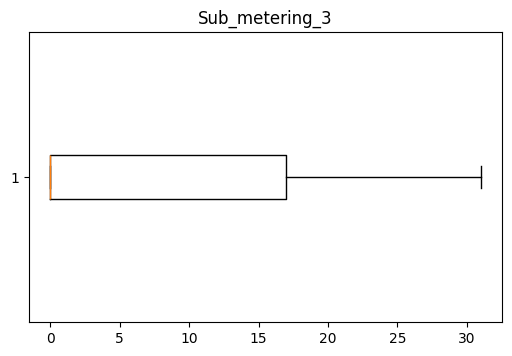

In [10]:
# Plotting the boxplots for the original dataset to visualize the outliers
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df[col], vert=False)
    plt.title(col)

plt.tight_layout()
plt.show()

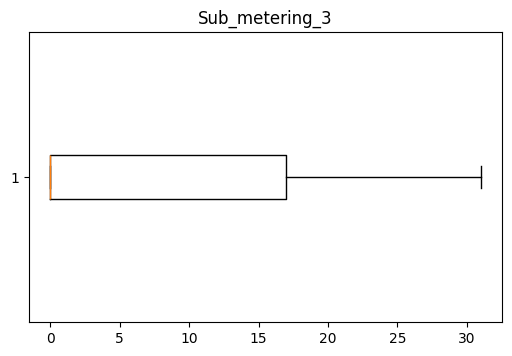

In [11]:
# Plotting the boxplots for the dataset after taking care of the outliers
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df_cleaned[col], vert=False)
    plt.title(col)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.ensemble import IsolationForest

# Prepare the data for anomaly detection
features = ['Global_active_power', 'Voltage', 'Global_intensity']
data_subset = df_cleaned[features].dropna()

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
data_subset['anomaly'] = iso_forest.fit_predict(data_subset)

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.plot(data_subset.index, data_subset['Global_active_power'], label='Global Active Power', color='blue')
plt.scatter(
    data_subset.index[data_subset['anomaly'] == -1],
    data_subset['Global_active_power'][data_subset['anomaly'] == -1],
    color='red',
    label='Anomalies'
)
plt.title('Anomaly Detection in Power Consumption')
plt.legend()
plt.show()


ValueError: could not convert string to float: '?'

In [14]:
from sklearn.decomposition import PCA

# Select features for PCA
pca_features = df_cleaned.drop(['Cluster'], axis=1).dropna()

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_features)

# Add PCA components to the data
df_cleaned['PCA1'] = pca_result[:, 0]
df_cleaned['PCA2'] = pca_result[:, 1]

# Visualize PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_cleaned, palette='Set1')
plt.title('PCA Analysis of Power Consumption Patterns')
plt.show()


KeyError: "['Cluster'] not found in axis"

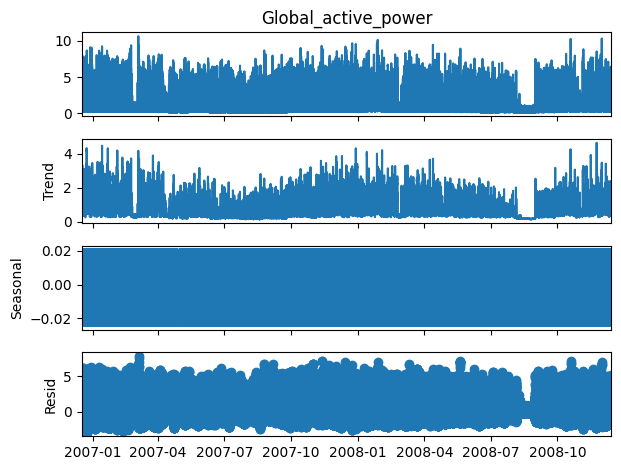

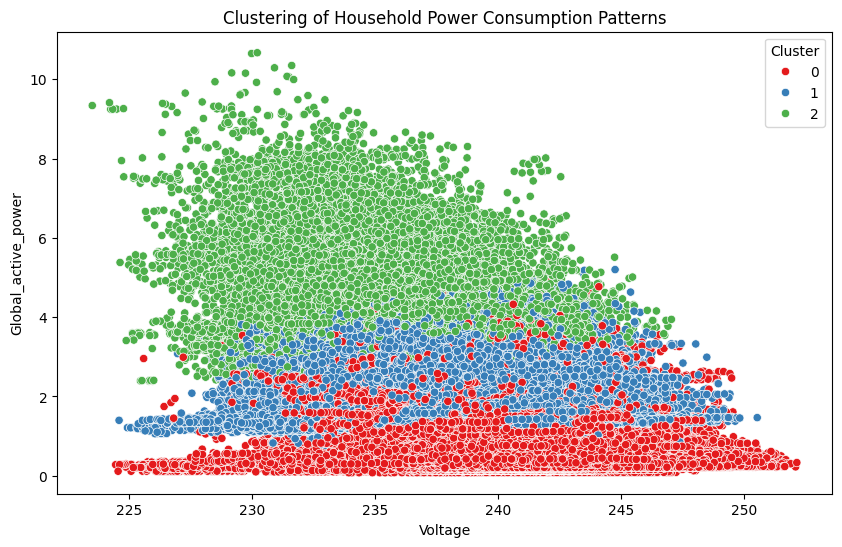

Mean Squared Error: 0.0011405940610587785
R^2 Score: 0.9991101830755051


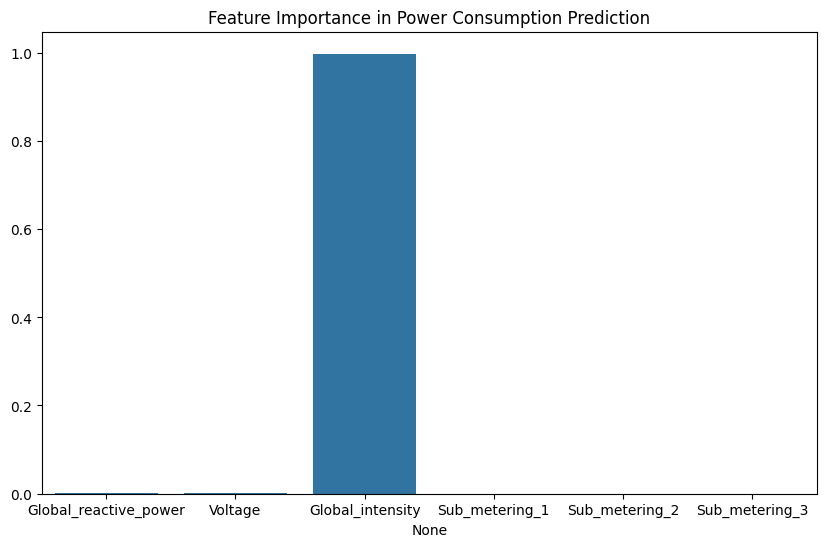

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert to proper data types
df_cleaned['Global_active_power'] = pd.to_numeric(df_cleaned['Global_active_power'], errors='coerce')
df_cleaned['Global_reactive_power'] = pd.to_numeric(df_cleaned['Global_reactive_power'], errors='coerce')
df_cleaned['Voltage'] = pd.to_numeric(df_cleaned['Voltage'], errors='coerce')
df_cleaned['Global_intensity'] = pd.to_numeric(df_cleaned['Global_intensity'], errors='coerce')
df_cleaned['Sub_metering_1'] = pd.to_numeric(df_cleaned['Sub_metering_1'], errors='coerce')
df_cleaned['Sub_metering_2'] = pd.to_numeric(df_cleaned['Sub_metering_2'], errors='coerce')
df_cleaned['Sub_metering_3'] = pd.to_numeric(df_cleaned['Sub_metering_3'], errors='coerce')

# Drop rows with missing values
df_cleaned.dropna(inplace=True)

# Ensure the 'Date' column is in datetime format
df_cleaned['DateTime'] = pd.to_datetime(df_cleaned['DateTime'])

# Set the 'Date' column as the index
df_cleaned.set_index('DateTime', inplace=True)

# Handle missing values
df_cleaned['Global_active_power'] = df_cleaned['Global_active_power'].interpolate(method='time')

# Time-Series Decomposition
# Reduced period to accommodate data size.
# The period should be less than half the size of the data.
decomposition = seasonal_decompose(df_cleaned['Global_active_power'], model='additive', period=364)
decomposition.plot()
plt.show()

# Scaling the data for clustering
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned)

# Clustering using K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Adding cluster labels to the data
df_cleaned['Cluster'] = clusters

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Voltage', y='Global_active_power', hue='Cluster', palette='Set1')
plt.title('Clustering of Household Power Consumption Patterns')
plt.show()

# Preparing data for regression
X = df_cleaned.drop(['Global_active_power', 'Cluster'], axis=1)
y = df_cleaned['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Feature Importance
importance = regressor.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=importance)
plt.title('Feature Importance in Power Consumption Prediction')
plt.show()


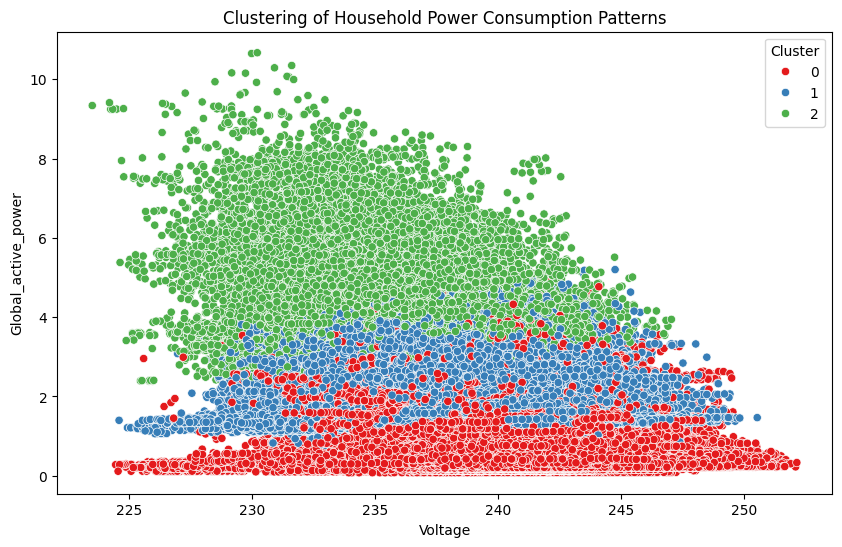

KeyboardInterrupt: 

In [21]:
# Adding cluster labels to the data
df_cleaned['Cluster'] = clusters

# Visualizing clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='Voltage', y='Global_active_power', hue='Cluster', palette='Set1')
plt.title('Clustering of Household Power Consumption Patterns')
plt.show()

# Preparing data for regression
X = df_cleaned.drop(['Global_active_power', 'Cluster'], axis=1)
y = df_cleaned['Global_active_power']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a regression model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predictions
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Feature Importance
importance = regressor.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns, y=importance)
plt.title('Feature Importance in Power Consumption Prediction')
plt.show()


In [ ]:
# Advanced Regression Analysis with Feature Engineering and Model Selection

# ... (Your existing code) ...

# Feature Engineering: Create new features based on existing ones
df_cleaned['Daily_Consumption'] = df_cleaned['Global_active_power'] * 24  # Total daily consumption
df_cleaned['Voltage_Intensity_Ratio'] = df_cleaned['Voltage'] / df_cleaned['Global_intensity']
df_cleaned['Reactive_Active_Ratio'] = df_cleaned['Global_reactive_power'] / df_cleaned['Global_active_power']

# Assuming 'DateTime' is the index of df_cleaned
# If 'DateTime' is a column, change daily_data.index to daily_data['DateTime'] = pd.to_datetime(daily_data.index)
daily_data = df_cleaned.groupby(df_cleaned.index.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'Daily_Consumption': 'sum',
    'Voltage_Intensity_Ratio': 'mean',
    'Reactive_Active_Ratio': 'mean'
})

daily_data.index = pd.to_datetime(daily_data.index)

# ... (rest of your code) ...
# Handle missing values in daily_data before scaling and clustering
daily_data = daily_data.fillna(method='ffill') # Forward fill missing values

# Advanced Model Selection: Try different regression models with hyperparameter tuning
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

models = {
    'RandomForest': RandomForestRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR()
}

param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Ridge': {'alpha': [0.1, 1, 10]},
    'Lasso': {'alpha': [0.1, 1, 10]},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
}

best_model = None
best_r2 = -float('inf')

for model_name, model in models.items():
    param_grid = param_grids.get(model_name)
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        r2 = grid_search.best_score_

        if r2 > best_r2:
            best_r2 = r2
            best_model = model

# Fit the best model on the entire training data
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Best Model: {best_model}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


# Analyze Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Further analysis can be done to assess the model's assumptions and address any issues.


<ipython-input-22-6850417c9f6b>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_data = daily_data.fillna(method='ffill') # Forward fill missing values


In [ ]:
import shap

# Train the model again
regressor.fit(X_train, y_train)

# Use SHAP for interpretability
explainer = shap.Explainer(regressor, X)
shap_values = explainer(X)

# Plot summary plot
shap.summary_plot(shap_values, X, plot_type='bar')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_data['Global_active_power'].values.reshape(-1, 1))

# Create sequences
seq_len = 30
X_lstm = []
y_lstm = []
for i in range(seq_len, len(scaled_data)):
    X_lstm.append(scaled_data[i-seq_len:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32)

# Predict future values
predictions = model.predict(X_lstm)
predictions = scaler.inverse_transform(predictions)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index[seq_len:], scaler.inverse_transform(scaled_data[seq_len:]), label='Actual')
plt.plot(df_cleaned.index[seq_len:], predictions, label='Predicted', color='red')
plt.title('LSTM Forecast of Global Active Power')
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(daily_data['Global_active_power'].interpolate(), order=(5, 1, 0))
arima_result = model.fit()

# Forecast future values
forecast = arima_result.forecast(steps=30)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Historical Data')
plt.plot(pd.date_range(daily_data.index[-1], periods=30, freq='D'), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Global Active Power')
plt.legend()
plt.show()


In [ ]:
trend_strength = 1 - (np.var(decomposition.resid) / np.var(decomposition.trend + decomposition.resid))
seasonality_strength = 1 - (np.var(decomposition.resid) / np.var(decomposition.seasonal + decomposition.resid))

print(f"Trend Strength: {trend_strength}")
print(f"Seasonality Strength: {seasonality_strength}")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to calculate and display performance metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\nPerformance Metrics for {model_name}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2}")
    return mae, mse, rmse, r2

# 1. Evaluating Random Forest Regression Model
rf_y_pred = regressor.predict(X_test)  # Predicted values from Random Forest
evaluate_model(y_test, rf_y_pred, "Random Forest Regressor")

# 2. Evaluating ARIMA Model
arima_forecast = arima_result.forecast(steps=len(y_test))  # Forecasted values from ARIMA
arima_y_test = daily_data['Global_active_power'][-len(arima_forecast):]  # Matching y_test for ARIMA
evaluate_model(arima_y_test, arima_forecast, "ARIMA")

# 3. Evaluating LSTM Model
# Reshape and scale back the LSTM predictions for evaluation
lstm_predictions = scaler.inverse_transform(predictions)
lstm_actual = scaler.inverse_transform(scaled_data[seq_len:])  # Corresponding actual values
evaluate_model(lstm_actual, lstm_predictions, "LSTM Model")

# 4. For Clustering, Evaluating Cluster Performance with Silhouette Score (Optional)
from sklearn.metrics import silhouette_score

clustering_features = scaler.fit_transform(daily_data.drop(['Cluster'], axis=1).dropna())
silhouette_avg = silhouette_score(clustering_features, kmeans.labels_)
print(f"\nSilhouette Score for K-Means Clustering: {silhouette_avg}")
